In [2]:
%pylab inline
%load_ext Cython

Populating the interactive namespace from numpy and matplotlib


In [3]:
from SuchTree import SuchTree
import seaborn

### Calculating distances

`SuchTree` has two ways approaches for calculating distances. One pair a time, or
several large groups of pairs at once. The large groups is more efficient because
it does each calculation without the interpreter's overhead. 

Note that the dendrograms in the cluster maps are re-computed from the distances 
in the matrix using neighbor joining, and so they do not exactly match the phylogeny
which was computed using a different method.

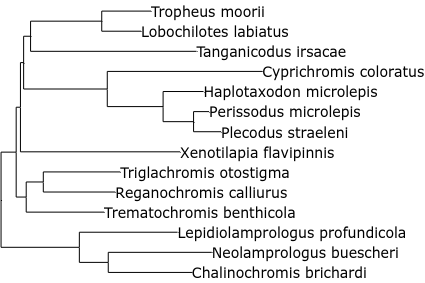

In [3]:
from ete2 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0

ete_tree = Tree( '../fishpoo/mcgee_trimmed.tree' )

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 10
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)

In [3]:
#T = SuchTree( 'SuchTree/tests/test.tree')
T = SuchTree( '../fishpoo/mcgee_trimmed.tree' )

In [4]:
D1 = zeros( ( len(T.leafs),len(T.leafs) ) )
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D1[i,j] = T.distance( a, b )

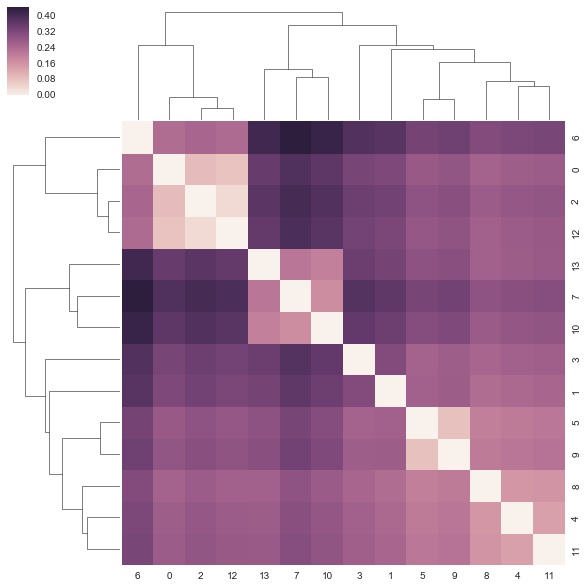

In [5]:
seaborn.clustermap(D1)

In [7]:
D2_list = []
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D2_list.append( ( a, b ) )
D2_array = array( D2_list )
D2 = T.distances( D2_array )
D2 = D2.reshape( ( len(T.leafs), len(T.leafs) ) )

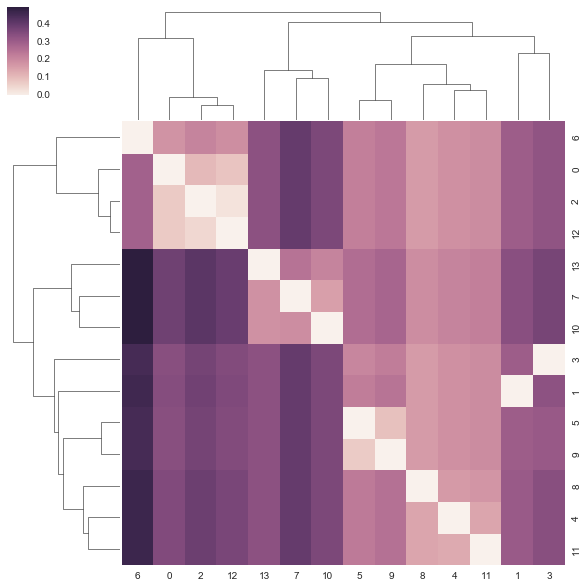

In [8]:
seaborn.clustermap(D2)

### Loading data from URLs

SuchTree can also import data from the internets. Here is the distance matrix for 
the penguins, from the [Global Phylogeny of Birds](http://birdtree.org/).

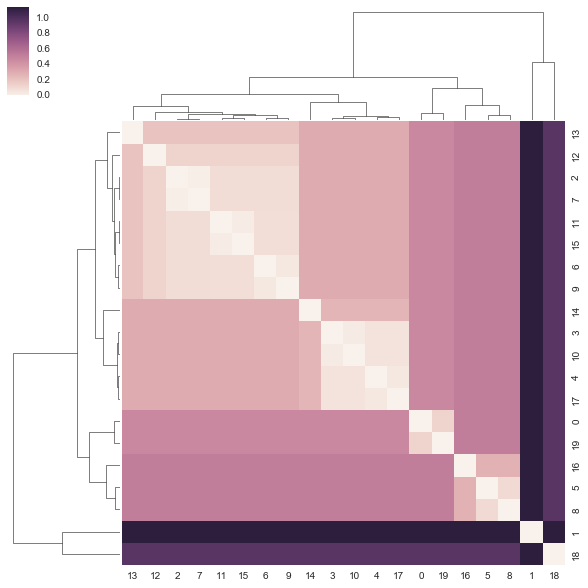

In [9]:
T = SuchTree( 'http://litoria.eeb.yale.edu/bird-tree/archives/PatchClade/Stage2/set1/Spheniscidae.tre' )

D3_list = []
for i,a in enumerate(T.leafs.values()) :
    for j,b in enumerate( T.leafs.values() ) :
        D3_list.append( ( a, b ) )
D3_array = array( D3_list )
D3 = T.distances( D3_array )
D3 = D3.reshape( ( len(T.leafs), len(T.leafs) ) )

seaborn.clustermap(D3)

### Comparing the topologies of two large trees

Here, we use `SuchTree` to compare the topology of a two trees containing the taxa
but constructe with different methods ([`FastTree`](http://www.microbesonline.org/fasttree/) and 
[`neighbor joining`](https://en.wikipedia.org/wiki/Neighbor_joining)). One million random pairs are 
sampled from each tree, and the distances compared.

On my [rather elderly laptop](https://en.wikipedia.org/wiki/ThinkPad_X_Series#X200s), 
the distance calculations in both trees are completed in 22 seconds (most of which
is mapping the names to the node indicies).

In [6]:
T1 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )
T2 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree_nj.tree' )

print 'nodes : %d, leafs : %d' % ( T1.length, len(T1.leafs) )
print 'nodes : %d, leafs : %d' % ( T2.length, len(T2.leafs) )

nodes : 108653, leafs : 54327
nodes : 108653, leafs : 54327


In [7]:
import random

N = 1000000

v = T1.leafs.keys()

pairs = []
for i in range(N) :
    pairs.append( ( random.choice( v ), random.choice( v ) ) )

%time D1, D2 = T1.distances_by_name( pairs ), T2.distances_by_name( pairs )

CPU times: user 18.4 s, sys: 20 ms, total: 18.4 s
Wall time: 18.4 s


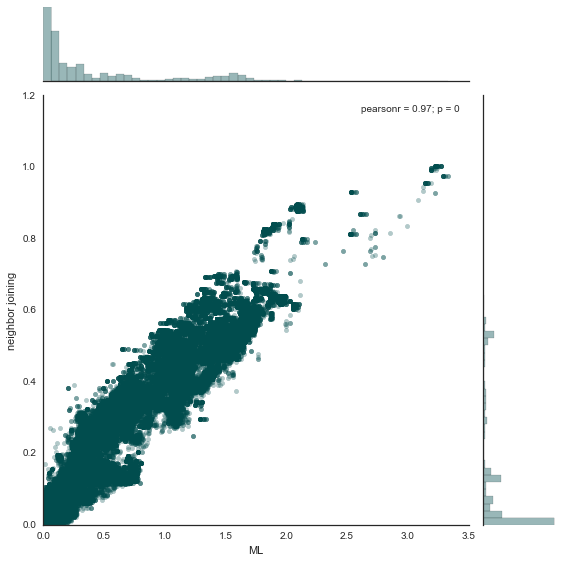

In [12]:
import pandas as pd


df = pd.DataFrame( { 'ML' : D1, 'neighbor joining' : D2 } )

with seaborn.axes_style("white"):
    seaborn.jointplot( 'ML', 'neighbor joining', data=df, color=seaborn.xkcd_rgb['dark teal'], alpha=0.3,
                       xlim=(0,3.5), ylim=(0,1.2), size=8 )

In [86]:
from scipy.stats import spearmanr, kendalltau, pearsonr

print 'Spearman\'s rs : %0.3f' % spearmanr( D1, D2 )[0]
print 'Kendall\'s tau : %0.3f' % kendalltau( D1, D2 )[0]
print 'Pearson\'s r   : %0.3f' % pearsonr( D1, D2 )[0]

Spearman's rs : 0.876
Kendall's tau : 0.708
Pearson's r   : 0.969


### Running with multiple threads

Another advantage of `SuchTree`'s support for performing batches of distance 
calculations is that these calculations can run outside of Python's 
[global interpreter lock](https://lbolla.info/blog/2013/12/23/python-threads-cython-gil).
This makes it possible to parallelize with [Threads](https://docs.python.org/2/library/threading.html).
Python's `Thread` has less overhead than the
[multiprocessing](https://docs.python.org/2/library/multiprocessing.html) package's
`Process`, and `Thread` objects can access the same memory. 

`SuchTree` intentionally does not allow the user to alter trees once they are created,
and so distance calculations are always thread safe. This makes it possible to use only 
*one* instance of a tree for all threads, which ought to give you the best chance of
keeping it within L2 cache.

In [14]:
%load_ext Cython

In [15]:
%%cython
import cython

def correlation( double[:] x, double[:] y ) :
    return _correlation( x, y )

@cython.boundscheck(False)
cdef double _correlation( double[:] x, double[:] y ) :
    cdef int n = x.shape[0]
    cdef int i = 0
    cdef double r = 0.0
    cdef double xbar = 0.0
    cdef double ybar = 0.0
    cdef double sx = 0.0
    cdef double sy = 0.0

    with nogil :
        for i in xrange(n) :
            xbar += x[i]
            ybar += y[i]
        xbar /= n
        ybar /= n
        
        # compute standard deviation of x and y
        for i in xrange(n) :
            sx += (x[i] - xbar) * (x[i] - xbar)
            sy += (y[i] - ybar) * (y[i] - ybar)
        
        sx = ( sx / n )**(0.5)
        sy = ( sy / n )**(0.5)
        
        # compute r, the correlation coefficient between the two arrays
        for i in xrange(n) :
            r += (((x[i] - xbar)/sx) * ((y[i] - ybar)/sy));
        r /= (n);
        return r

In [16]:
from threading import Thread
from Queue import Queue

n = 2
m = 12

work_q = Queue()
done_q = Queue()

for i in xrange( m ) :
    work_q.put( pairs )

for i in xrange( n ) :
    work_q.put( 'STOP' )
    
def worker( work_q, done_q ) :
    for task in iter( work_q.get, 'STOP' ) :
        D1 = T1.distances_by_name( task )
        D2 = T2.distances_by_name( task )
        r = correlation( D1, D2 )
        done_q.put( r )
    return True

threads = []

for i in xrange( n ) :
    thread = Thread( target=worker, args=( work_q, done_q ) )
    thread.start()
    threads.append( thread )
    
for thread in threads :
    thread.join()

done_q.put( 'STOP' )

for r in iter( done_q.get, 'STOP' ) :
    print r

0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425
0.968953943425


In [10]:
import pandas as pd

links = pd.read_csv( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_host_count_table.tsv', 
                    sep='\t', index_col='Host')
links.index = map( lambda x : x.replace(' ','_'), links.index )

In [11]:
def foundon( df  ) :
    s = df.unstack()
    return s[ s > 0].to_dict().keys()

len(foundon(links))

149692

In [92]:
from itertools import combinations
import pyprind

N = len(list(T1.get_internal_nodes()))

sfael = dict( zip( T1.leafs.values(), T1.leafs.keys() ) )

def paired_distances( id ) :
    clade = map( lambda x : sfael[x], T1.get_leafs(id) )
    if len(clade) > 500 : raise Exception( 'clade too big', id )
    if len(clade) < 6 :   raise Exception( 'clade too small', id )
    l = foundon(links[clade])
    if len(l) < 10 : raise Exception( 'too few links', id )
    gpairs, hpairs = [],[]
    for (g1,h1),(g2,h2) in combinations( l, 2 ) :
        gpairs.append( (g1,g2) )
        hpairs.append( (h1,h2) )
    gd = T1.distances_by_name( gpairs )
    hd = T.distances_by_name( hpairs )
    return { 'length' : len(clade), 'n_links' : len(l), 'guest distances' : gd, 'host distances' : hd }

progbar = pyprind.ProgBar( N, monitor=True, title='computing distances...' )

results = []
for n,id in enumerate( T1.get_internal_nodes() ) :
    progbar.update()
    #if n > N : break
    try :
        result = paired_distances( id )
        row = {}
        pr,pp = pearsonr( result['guest distances'], result['host distances'] )
        sr,sp = spearmanr( result['guest distances'], result['host distances'] )
        row[ 'pearsonr' ] = pr
        row[ 'pearsonp' ] = pp
        row[ 'spearmanr' ] = sr
        row[ 'spearmanp' ] = sp
        row[ 'length' ] = result[ 'length' ]
        row[ 'n_links' ] = result[ 'n_links' ]
        row[ 'id' ] = id
        results.append( row )
    except Exception as error :
        continue
    

computing distances...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:42:06


In [94]:
result = paired_distances( sorted(results, key=lambda x : x['pearsonr'] )[-1]['id'] )
seaborn.jointplot(result['guest distances'], result['host distances'] )

KeyError: 'id'

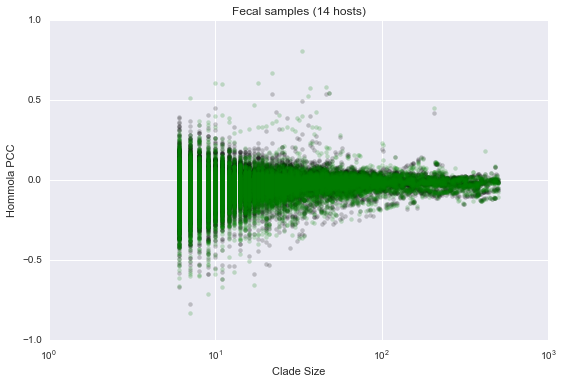

In [95]:
R = pd.DataFrame( results )

scatter( R.length, R.spearmanr, lw=0, c='k', alpha=0.2 )
scatter( R.length, R.pearsonr, lw=0, c='g', alpha=0.2 )
title( 'Fecal samples (14 hosts)')
xlabel( 'Clade Size' )
ylabel( 'Hommola PCC' )
semilogx()
tight_layout()

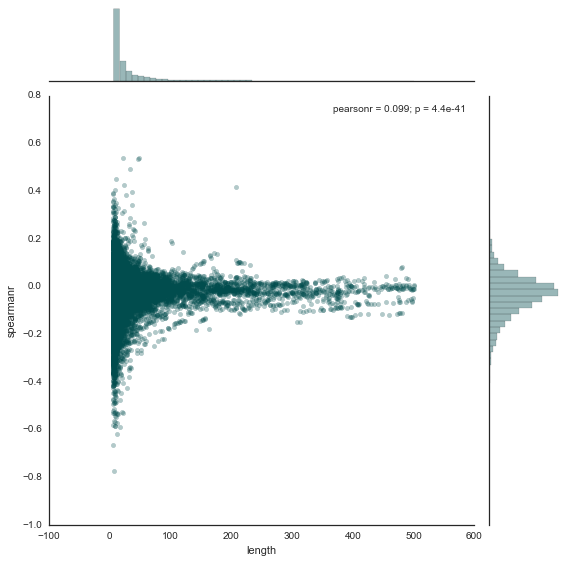

In [100]:
with seaborn.axes_style("white"):
    seaborn.jointplot( 'length', 'spearmanr', data=R, color=seaborn.xkcd_rgb['dark teal'], alpha=0.3, size=8 )

In [107]:
%%cython
import SuchTree
cimport SuchTree

cdef class SuchLinkedTrees(SuchTree.SuchTree.SuchTree) :
    def __init__( self ) :
        print 'foo'


Error compiling Cython file:
------------------------------------------------------------
...
import SuchTree
cimport SuchTree

cdef class SuchLinkedTrees(SuchTree.SuchTree.SuchTree) :
    ^
------------------------------------------------------------

/home/russell/.cache/ipython/cython/_cython_magic_bd54ca1eed4cea0f9103407d52ee7ee0.pyx:4:5: 'SuchTree/SuchTree.pxd' not found

Error compiling Cython file:
------------------------------------------------------------
...
import SuchTree
cimport SuchTree

cdef class SuchLinkedTrees(SuchTree.SuchTree.SuchTree) :
    ^
------------------------------------------------------------

/home/russell/.cache/ipython/cython/_cython_magic_bd54ca1eed4cea0f9103407d52ee7ee0.pyx:4:5: 'SuchTree' is not declared


In [1]:
from SuchTree import SuchTree, SuchLinkedTrees

In [ ]:
LT = SuchLinkedTrees( '../fishpoo/mcgee_trimmed.tree', '' )